# NHL Canucks - Retention Score Distribution
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Feb 28, 2022

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from datetime import datetime
from pytz import timezone
from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [41]:
# connect to SQL Server.
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ····················


In [30]:
lkupclientid = 7 # canucks
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrCanucks].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(32920, 54)

### We should specify the features used in our model:

In [8]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "productGrouping",
    "recency",
    "recentDate",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (23643, 10)
Unseen Data For Predictions: (4172, 10)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [9]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=[
        "dimCustomerMasterId",
        "productGrouping",
        "recentDate",
        "year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [10]:
model_matrix = compare_models(
    fold= 10,
    include= ["gbc","lightgbm","lr","xgboost"],
    n_select=4
)
results = pull()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7837,0.8626,0.8089,0.7816,0.7949,0.5663,0.5669,0.3520
lightgbm,Light Gradient Boosting Machine,0.7706,0.8514,0.7820,0.7769,0.7793,0.5404,0.5406,0.1410
gbc,Gradient Boosting Classifier,0.7455,0.8189,0.7363,0.7640,0.7498,0.4910,0.4915,0.4020
lr,Logistic Regression,0.6473,0.7029,0.6223,0.6726,0.6464,0.2957,0.2967,0.0160


In [11]:
models = []
for idx, m in enumerate(model_matrix):
    
    model = create_model(m)
    final_model = finalize_model(model)
    
    models.append({
        "name": str(results.iloc[idx]["Model"]),
        "model": final_model
    })

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6214,0.6767,0.6046,0.6435,0.6235,0.2435,0.2440
1,0.6473,0.6991,0.6248,0.6718,0.6474,0.2955,0.2962
2,0.6552,0.7079,0.6353,0.6790,0.6564,0.3112,0.3119
3,0.6557,0.7069,0.6407,0.6772,0.6584,0.3119,0.3124
4,0.6617,0.7205,0.6340,0.6882,0.6600,0.3245,0.3256
5,0.6617,0.7183,0.6273,0.6910,0.6576,0.3248,0.3263
6,0.6406,0.6932,0.6167,0.6653,0.6401,0.2823,0.2831
7,0.6302,0.6858,0.5841,0.6623,0.6207,0.2626,0.2646
8,0.6506,0.7121,0.6273,0.6753,0.6504,0.3021,0.3029
9,0.6491,0.7082,0.6282,0.6728,0.6498,0.2990,0.2997


### Let's load in our 2021 season data and get retention scores using the model:

In [12]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(5105, 10)

In [13]:
predictions = []
for idx, final_m in enumerate(models):
    
    predictions = (predict_model(final_m['model'], data=df_inference, raw_score=True))
    final_m["predictions"] = predictions

### We can create some histograms to visualize each model distribution:

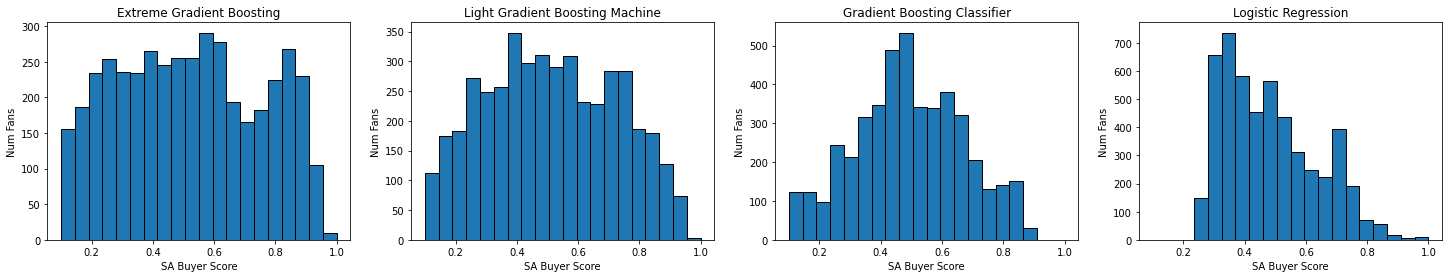

In [16]:
for idx, model in enumerate(models):
    
    plt.subplot(1, 4, idx+1)
    plt.title(model["name"])
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")
    plt.hist(model["predictions"]["Score_1"], bins=20, edgecolor="black", range=(0.1,1))
                            
plt.rcParams["figure.figsize"] = (25,4)
plt.show()

### We can also see how many purchases there are in each range of scores:

In [15]:
df_new = pd.DataFrame()

for idx, model in enumerate(models):
    df_new["Score"] = df_new.index
    df_new[str(models[idx]["name"])] = models[idx]["predictions"]["Score_1"].value_counts(bins=np.arange(0, 1, 0.05)).sort_index(ascending=False)

df_new.reset_index(inplace=True, drop=True)
df_new

,Score,Extreme Gradient Boosting,Light Gradient Boosting Machine,Gradient Boosting Classifier,Logistic Regression
0,"(0.9, 0.95]",129,103,0,10
1,"(0.85, 0.9]",270,151,73,18
2,"(0.8, 0.85]",313,207,166,79
3,"(0.75, 0.8]",209,272,161,111
4,"(0.7, 0.75]",187,327,170,430
5,"(0.65, 0.7]",201,252,329,258
6,"(0.6, 0.65]",314,255,442,267
7,"(0.55, 0.6]",317,335,355,345
8,"(0.5, 0.55]",285,313,412,514
9,"(0.45, 0.5]",267,343,564,592


### Select the model you would like to use for updating scores:

In [42]:
selected_model = "Light Gradient Boosting Machine"

for model in models:
    if model["name"] == selected_model:

        df_scores = model["predictions"]
                                 
df_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5105 entries, 27815 to 32919
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  5105 non-null   int64  
 1   attendancePercent    5105 non-null   float64
 2   distToVenue          5105 non-null   float64
 3   isNextYear_Buyer     5105 non-null   int64  
 4   productGrouping      5105 non-null   object 
 5   recency              5105 non-null   int64  
 6   recentDate           5105 non-null   object 
 7   source_tenure        5105 non-null   int64  
 8   totalSpent           5105 non-null   float64
 9   year                 5105 non-null   int64  
 10  Label                5105 non-null   int64  
 11  Score_0              5105 non-null   float64
 12  Score_1              5105 non-null   float64
dtypes: float64(5), int64(6), object(2)
memory usage: 558.4+ KB


### Optionally we can push these scores into QA so that we can see what the new scoring looks like in the CDP:

In [ ]:
date_time_now = datetime.now().strftime("%m-%d-%Y %H:%M:%S")

cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)
cursor = cnxn.cursor()

for idx, row in df_scores.iterrows():
    try:
        fields = """
            INSERT INTO ds.customerScores (
                dimCustomerMasterId,
                attendancePercentage,
                buyer_score,
                tenuredays,
                mostrecentattendance,
                year,
                lkupclientid,
                productgrouping,
                seasonYear,
                insertDate
            )
        """
        values = f"""
            VALUES (
                {str(row["dimCustomerMasterId"])},
                {str(row["attendancePercent"])},
                {str(row["isNextYear_Buyer"])},
                {str(row["source_tenure"])},
                {str(row["recentDate"])},
                {str(row["year"])},
                {str(lkupclientid)},
                '{str(row["productGrouping"])}',
                {str(row["year"])},
                {str(date_time_now)}
            )
        """
        insert_statement = fields + values
        
        print(insert_statement)
        
        cursor.execute(insert_statement)
        CNXN.commit()
                            
    except Exception as err:
        print("ERROR INSERTING RETENTION SCORES TO DATABASE:", err)

cursor.close()
print("RETENTION SCORES WRITTEN TO DATABASE")

### Run the stored procedure to push scores from Data Science table to Stlr table:

In [ ]:
# connect to SQL Server.
lkupclientid = 7
cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)
cursor = cnxn.cursor()

today = datetime.now()
date_time = today.strftime("%m-%d-%Y %H:%M:%S")

try:
    # Insert Dataframe into SQL Server:
    for index, row in df_scores.iterrows():
        cursor.execute("INSERT INTO ds.customerScores (dimCustomerMasterId,buyer_score,tenuredays,attendancePercentage,mostrecentattendance,year,lkupclientid,productgrouping,seasonYear,insertDate) values(" + str(row.dimCustomerMasterId) + "," + str(round(row.Score_1,4))+ ","+ str(row.source_tenure)+ ","+ str(row.attendancePercent) + "," +"'"+ str(row.recentDate)+"'" + ","+ str(row.year) + "," + str(lkupclientid)+ ","+"'"+str(row.productGrouping)+"'"+","+str(row.year)+"," +"'"+str(date_time)+"'" + ")")

        cnxn.commit()

except Exception as err:
    print("ERROR INSERTING FEATURE IMPORTANCES TO DATABASE:", err)
        
cursor.close()

In [40]:
lkupclientid = 7
cursor = cnxn.cursor()

try:
    # run the stored proc to update the stlr fact tables
    cursor.execute(
        f"Exec [DataScience].[DW].[factCustomerretention_INCR_LOAD_procVersion] {lkupclientid}, 2021"
    )
    cnxn.commit()

except Exception as err:
    print("ERROR RUNNING RETENTION SCORE STORED PROCEDURE:", err)

ERROR RUNNING RETENTION SCORE STORED PROCEDURE: ('08S01', '[08S01] [Microsoft][ODBC Driver 17 for SQL Server]Communication link failure (0) (SQLExecDirectW)')
